In [ ]:
# %pip install scanpy

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score


In [2]:
adata1 = sc.read(r'dataset_extracted/GSM5201883/matrix.mtx.gz', cache=True).transpose()
adata1.var_names = pd.read_csv(r'dataset_extracted/GSM5201883/features.tsv.gz', header=None, sep='\t')[1]
adata1.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201883/barcodes.tsv.gz', header=None)[0])

In [3]:
adata1

AnnData object with n_obs × n_vars = 5538 × 33538

In [4]:
adata2 = sc.read(r'dataset_extracted/GSM5201884/matrix.mtx.gz', cache=True).transpose()
adata2.var_names = pd.read_csv(r'dataset_extracted/GSM5201884/features.tsv.gz', header=None, sep='\t')[1]
adata2.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201884/barcodes.tsv.gz', header=None)[0])

In [5]:
adata2

AnnData object with n_obs × n_vars = 10756 × 33538

In [6]:
adata3 = sc.read(r'dataset_extracted/GSM5201885/matrix.mtx.gz', cache=True).transpose()
adata3.var_names = pd.read_csv(r'dataset_extracted/GSM5201885/features.tsv.gz', header=None, sep='\t')[1]
adata3.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201885/barcodes.tsv.gz', header=None)[0])

In [7]:
adata3

AnnData object with n_obs × n_vars = 6753 × 33538

In [8]:
adata4 = sc.read(r'dataset_extracted/GSM5201886/matrix.mtx.gz', cache=True).transpose()
adata4.var_names = pd.read_csv(r'dataset_extracted/GSM5201886/features.tsv.gz', header=None, sep='\t')[1]
adata4.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201886/barcodes.tsv.gz', header=None)[0])

In [9]:
adata4

AnnData object with n_obs × n_vars = 9676 × 33538

In [10]:

# matrix file has row and column names, so remove them:
adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata3.var_names_make_unique()
adata4.var_names_make_unique()

In [11]:
adata_list = [adata1, adata2, adata3, adata4]
adata_merged = ad.AnnData.concatenate(*adata_list, join='outer')


C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [12]:

adata_merged.obs_names = pd.concat([pd.Series(adata1.obs_names), 
                              pd.Series(adata2.obs_names), 
                              pd.Series(adata3.obs_names), 
                              pd.Series(adata4.obs_names)], join='outer')


In [13]:
adata_merged.var_names = adata1.var_names

In [14]:
adata_merged.obs_names_make_unique()


In [15]:
adata = adata_merged

In [16]:
adata.shape

(32723, 33538)

In [17]:
num_cells = adata.shape[0]
num_genes = adata.shape[1]

print(f'Total number of cells: {num_cells}')
print(f'Total number of genes: {num_genes}')

Total number of cells: 32723
Total number of genes: 33538


# DATA PREPROCESSING 

### Show those genes that yield the highest fraction of counts in each single cell, across all cells



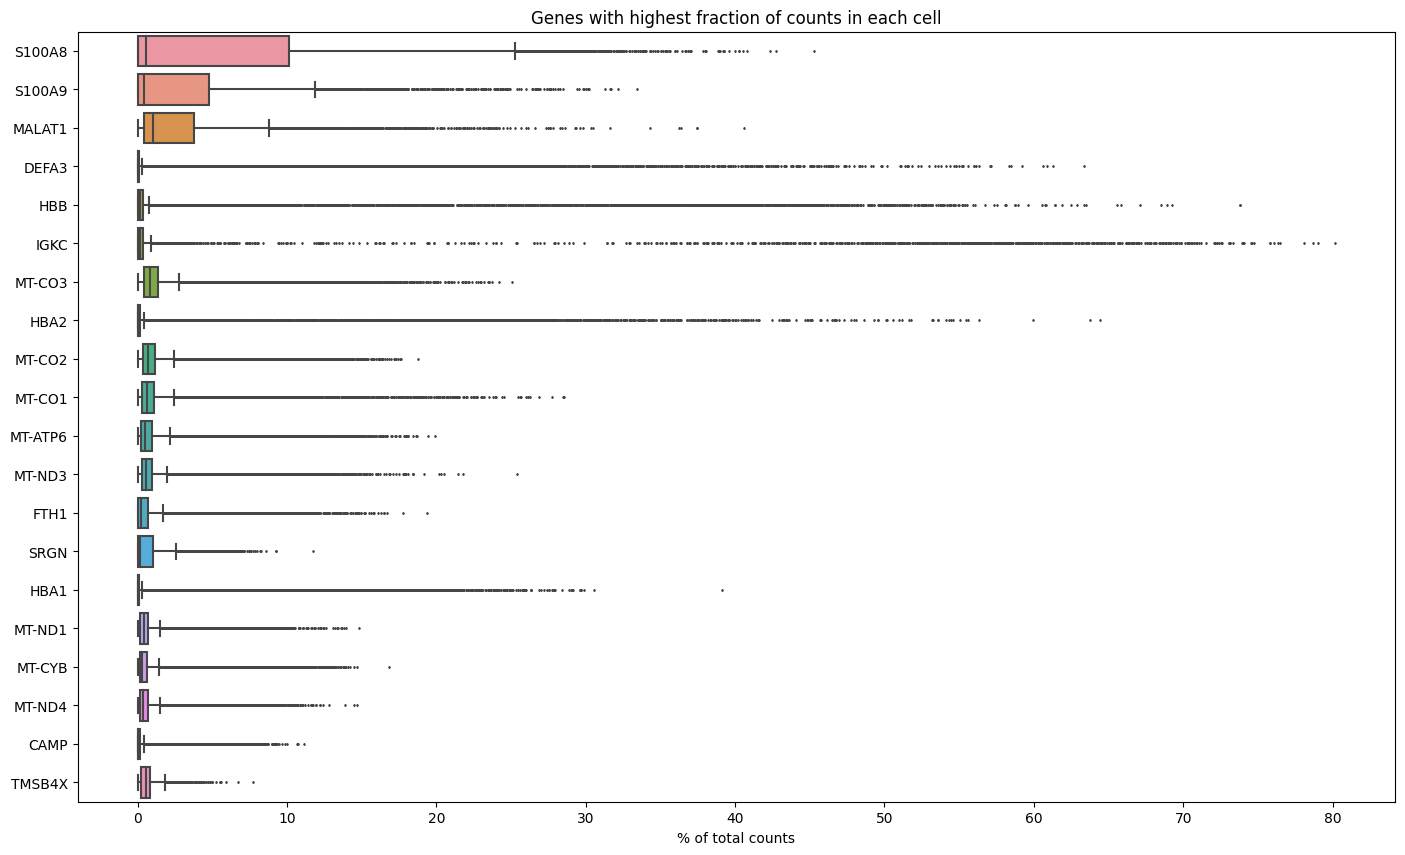

In [18]:
sc.pl.highest_expr_genes(adata, n_top=20, show=False)
fig = plt.gcf()
fig.set_size_inches(17, 10)

plt.title("Genes with highest fraction of counts in each cell")
plt.show()

### Filtering out cells that have less than 200 genes, and genes that are detected in less than 3 cells

In [19]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [20]:
num_cells = adata.shape[0]
num_genes = adata.shape[1]

print(f'Total number of cells: {num_cells}')
print(f'Total number of genes: {num_genes}')

Total number of cells: 31583
Total number of genes: 22589


In [21]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)

In [22]:
# Logarithamize the data
sc.pp.log1p(adata)


In [23]:
# %pip install leidenalg

### Identify highly-variable genes

In [24]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


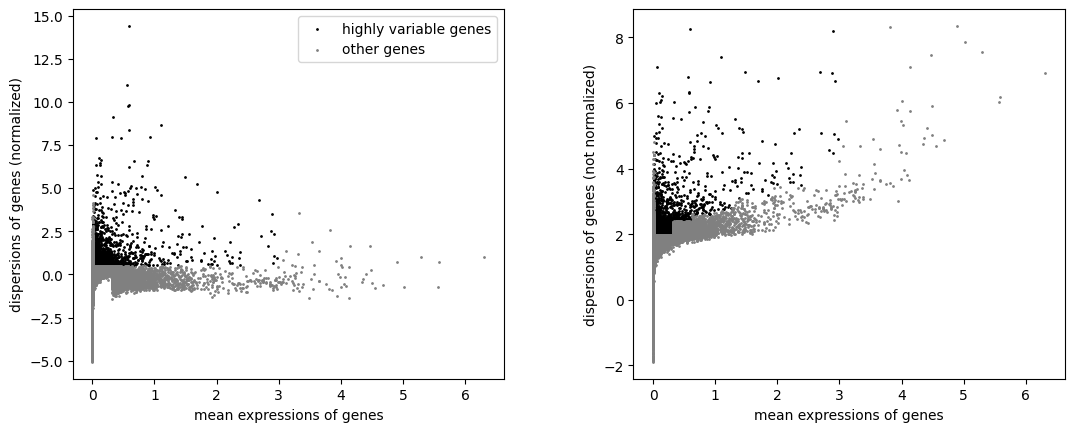

In [25]:
sc.pl.highly_variable_genes(adata)


In [26]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata


In [27]:
# Filtering:
adata = adata[:, adata.var.highly_variable]


In [28]:
# Scaling
sc.pp.scale(adata, max_value=10)


C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# PRINCIPLE COMPONENT ANALYSIS

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [29]:
sc.tl.pca(adata, svd_solver='arpack')


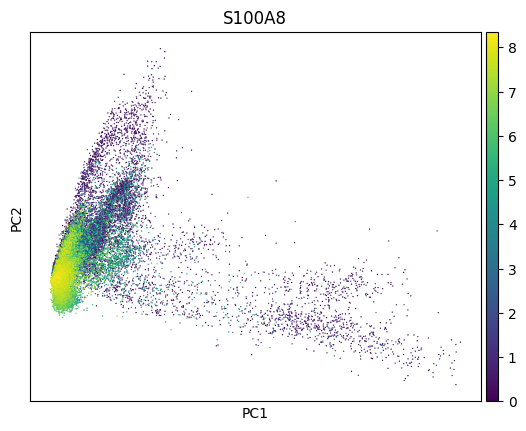

In [30]:
sc.pl.pca(adata, color='S100A8')


## Scatter Plot

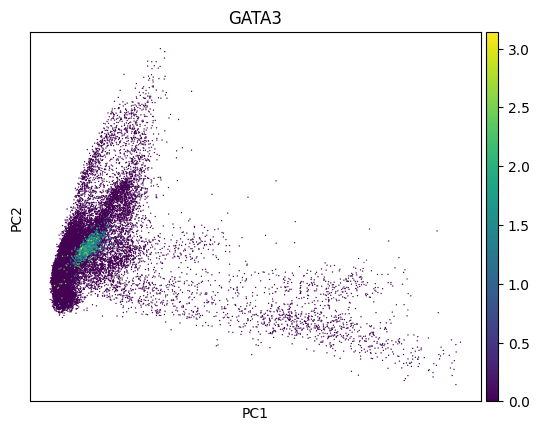

In [33]:
sc.pl.pca(adata, color='GATA3')


## Inspect the contribution of single PCs to the total variance in the data.
This gives us information about how many PCAs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). (Often a rough estimate of the number of PCs works).

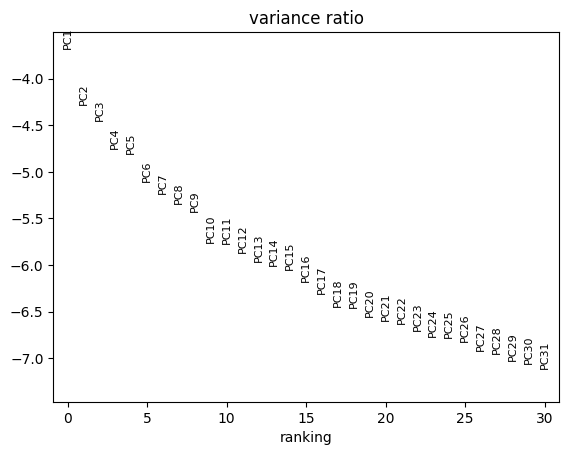

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)


In [35]:
adata.write("results_file.h5ad")


In [36]:
# adata

## Computing the Neighbourhood Graph

In [184]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=31)


## Embedding the neighborhood graph


Embedding the graph in two dimensions using UMAP (McInnes et al., 2018). 
It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [185]:
# pip install leidenalg

In [186]:
sc.tl.leiden(adata)


In [187]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False) 
sc.tl.umap(adata, init_pos='paga')

In [190]:
# Compute silhouette score
silhouette_scores = silhouette_score(
    adata.obsm['X_umap'],
    adata.obs['leiden'].values,
    metric='euclidean'
)

# Print mean silhouette score
print("Mean silhouette score:", silhouette_scores)

Mean silhouette score: 0.38305154


C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


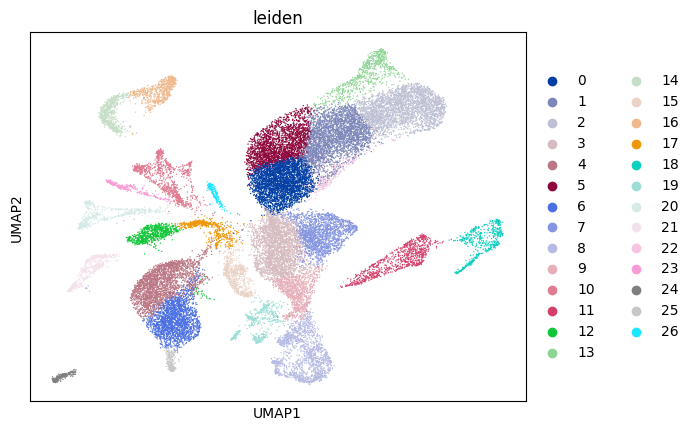

In [191]:
sc.pl.umap(adata, color=['leiden'])


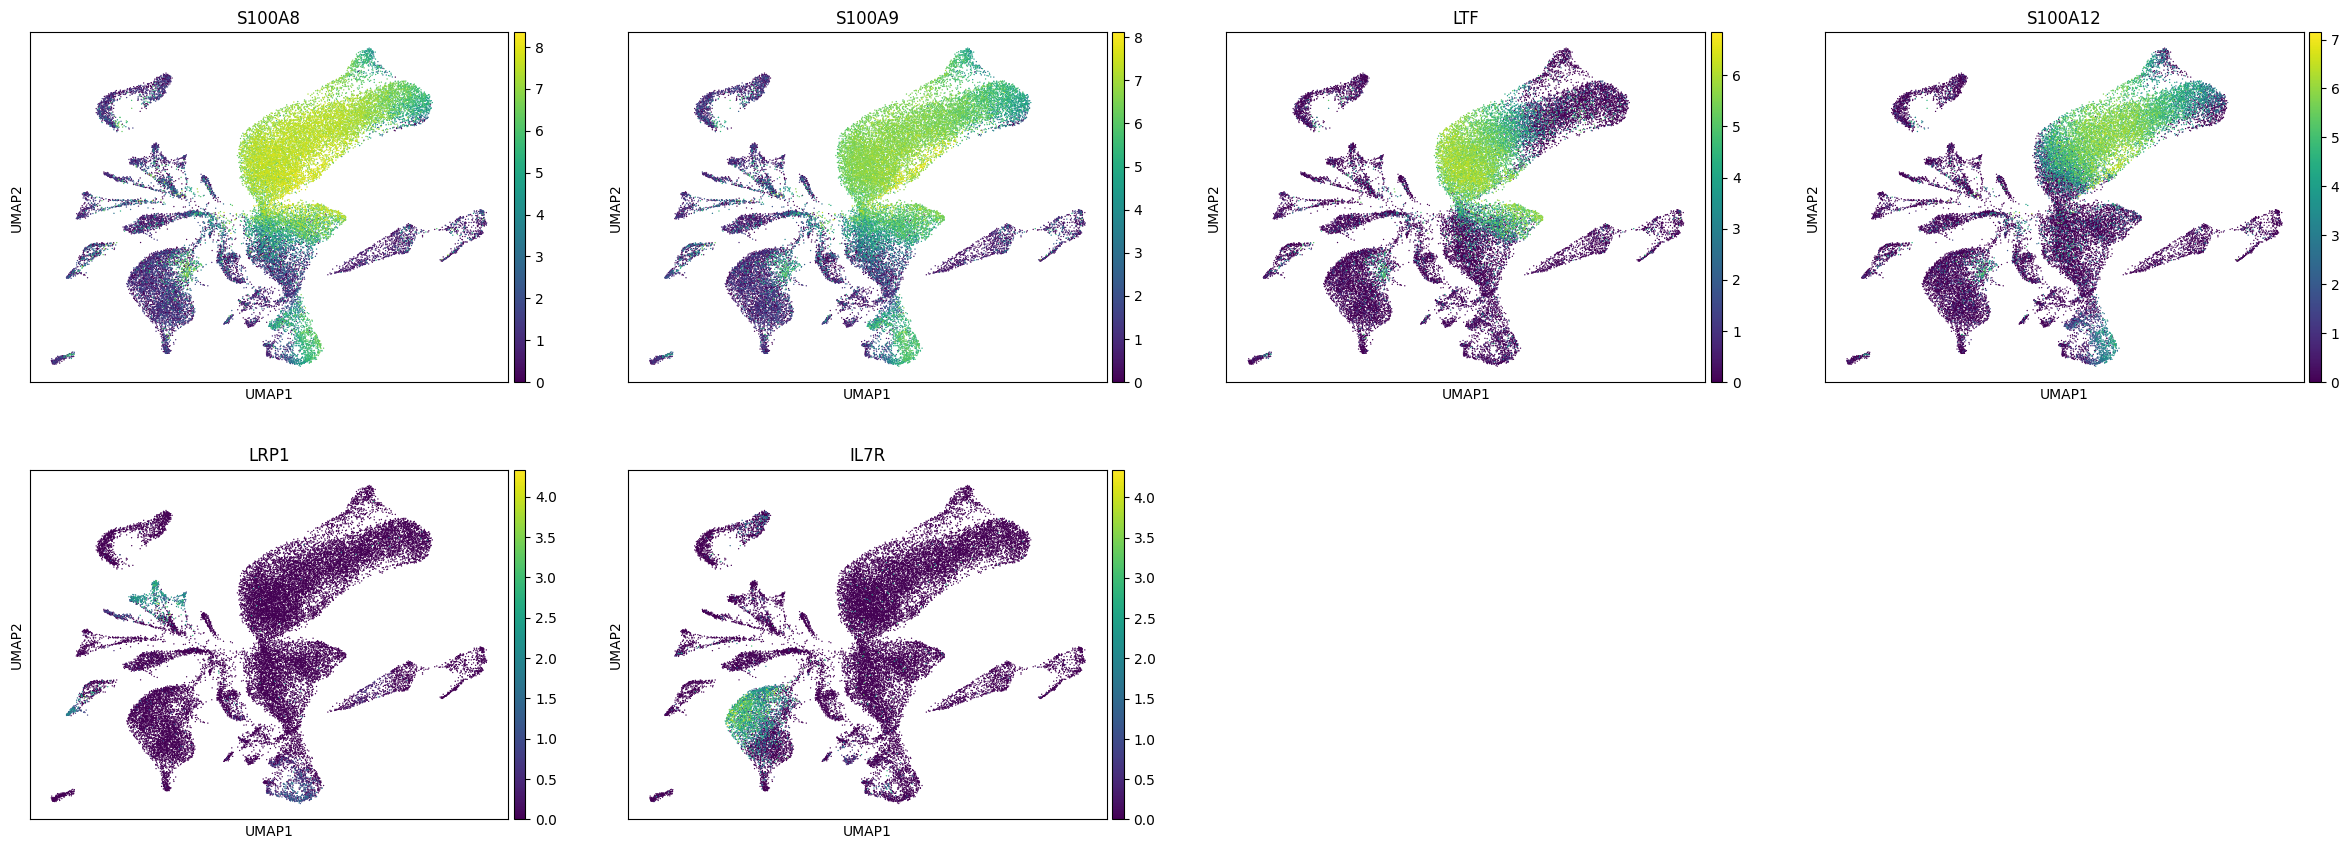

In [192]:
sc.pl.umap(adata, color=['S100A8','S100A9','LTF', 
                        'S100A12', 'LRP1', 'IL7R'])


### Clustering the neighborhood graph
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.


In [103]:
adata.write("results_file.h5ad")


## Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster.
For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the **t-test**.

C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_g

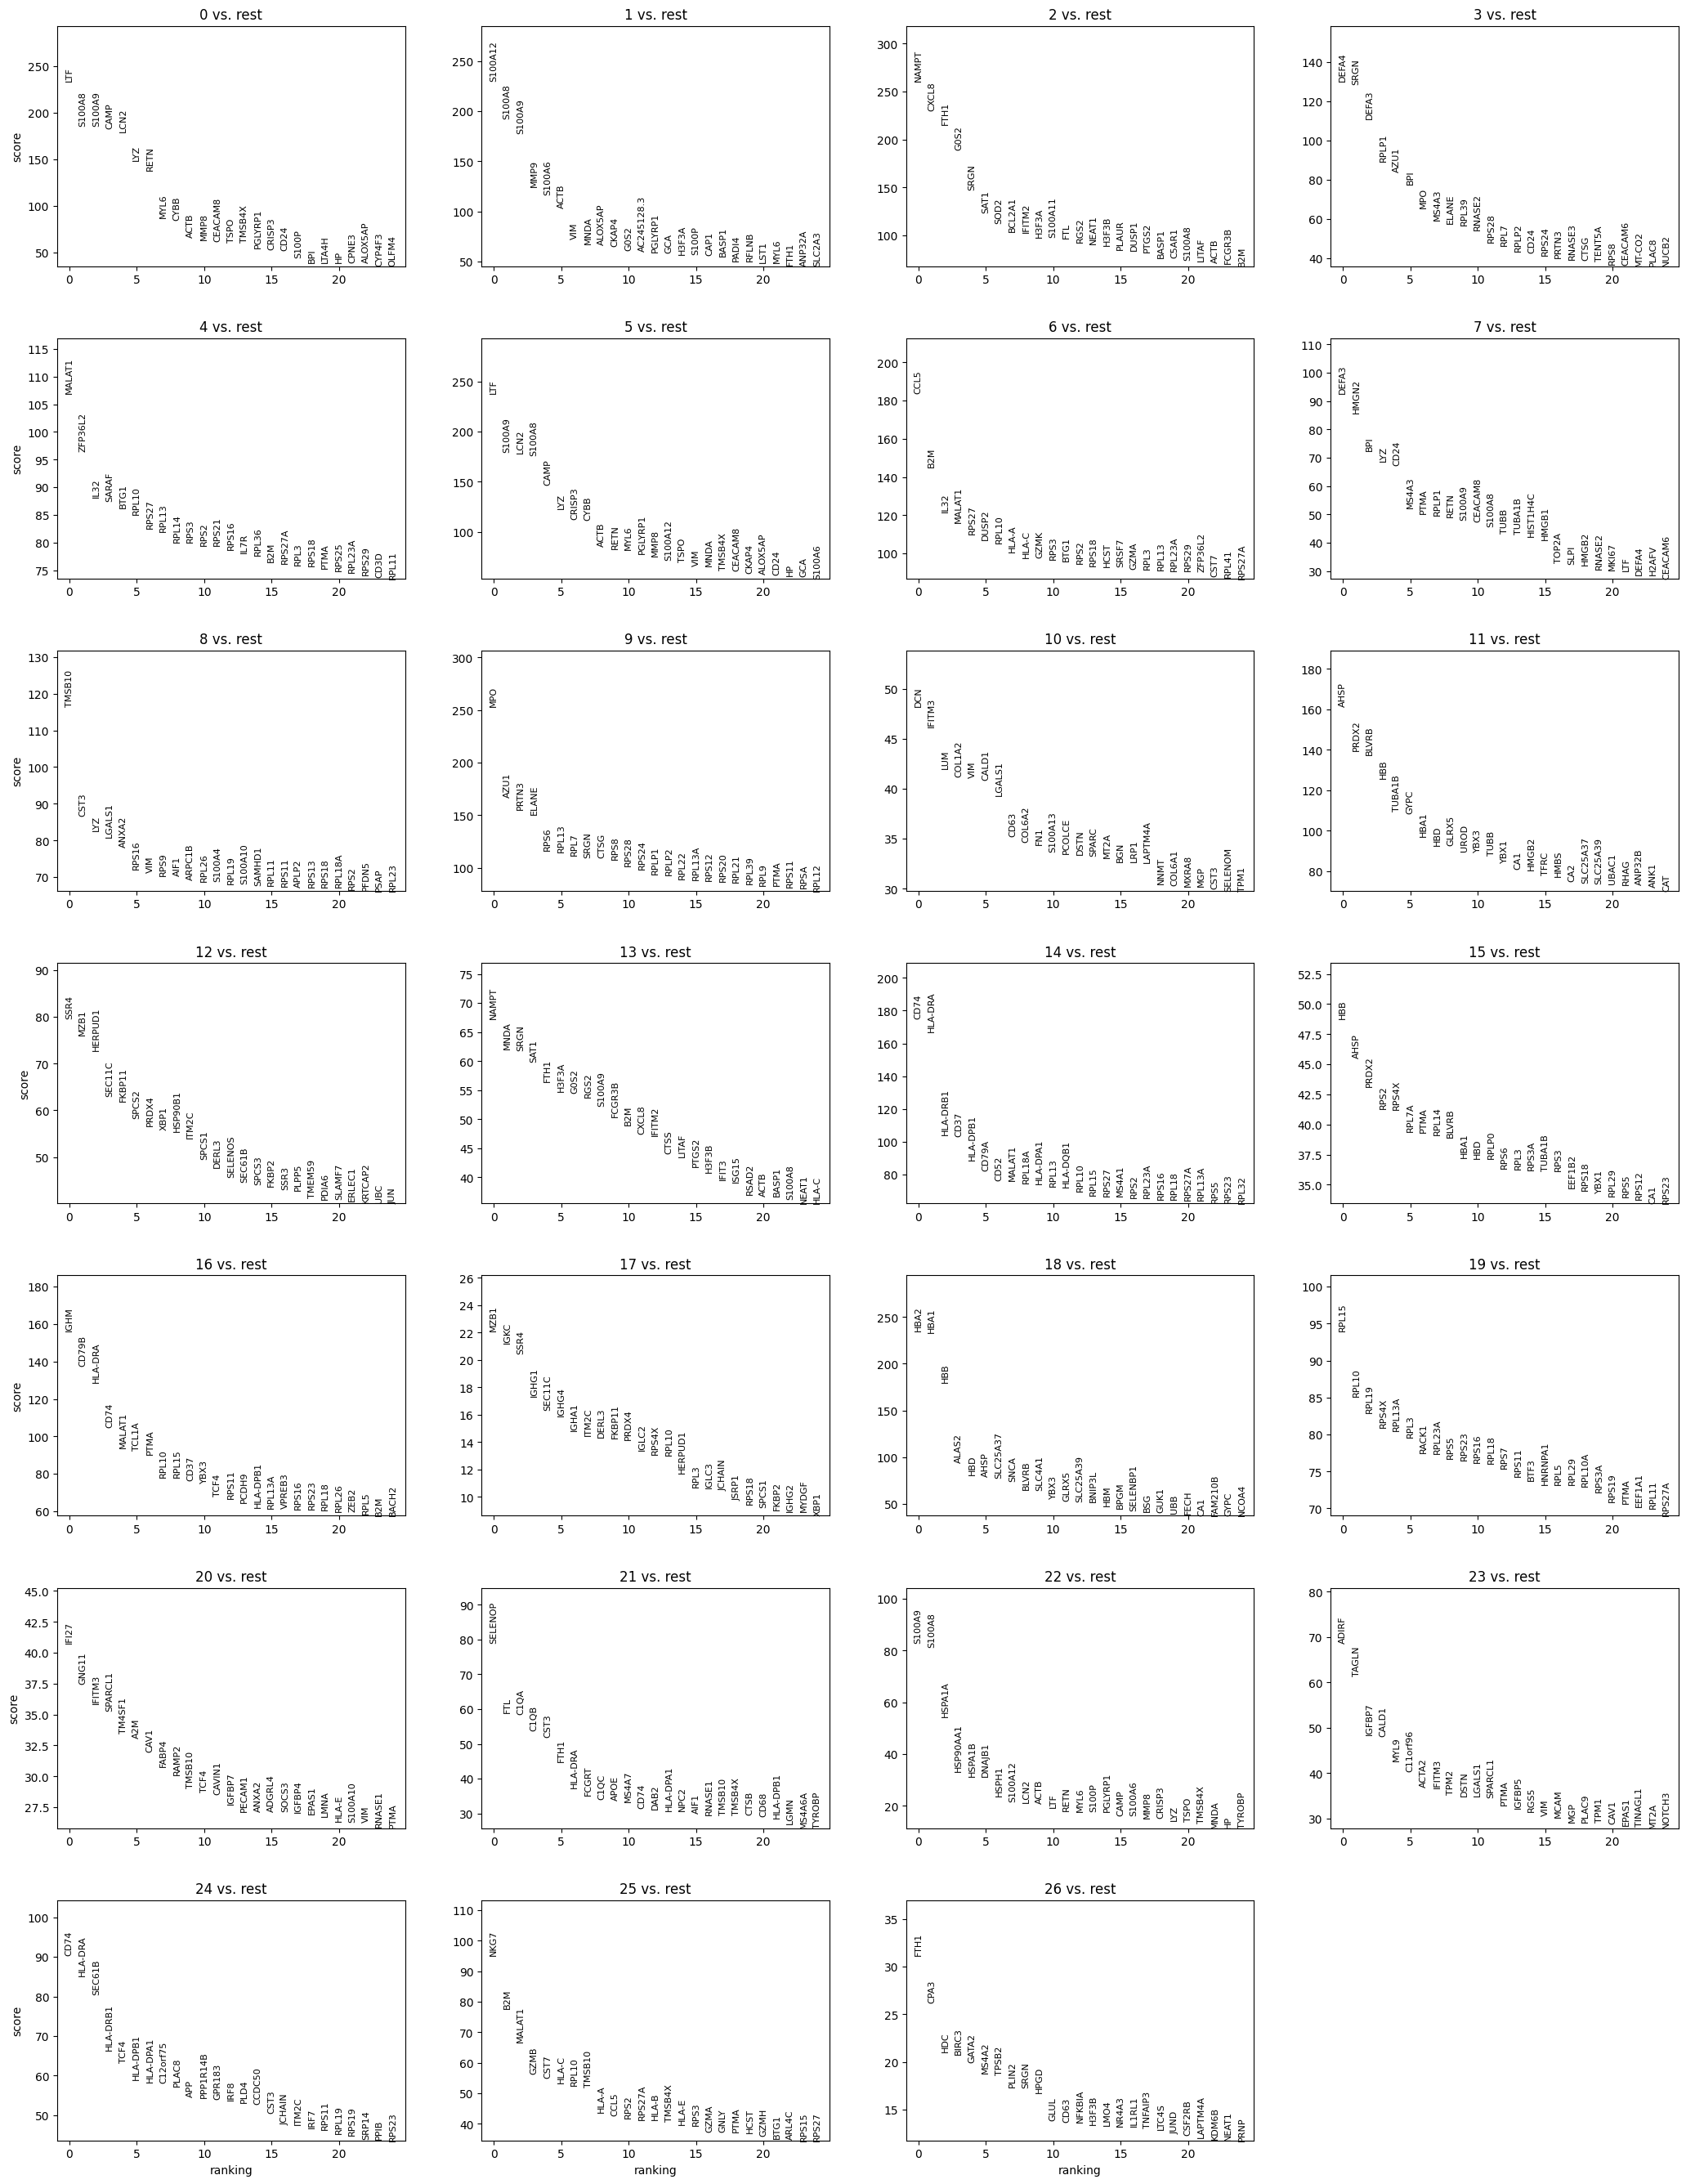

In [194]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [108]:
# This would return an array containing the names of the top 25 genes for the first cluster

top_genes_cluster1 = list(adata.uns['rank_genes_groups']['names'][0])[:25]
top_genes_cluster1

['LTF',
 'S100A12',
 'NAMPT',
 'DEFA4',
 'MALAT1',
 'LTF',
 'CCL5',
 'DEFA3',
 'TMSB10',
 'MPO',
 'DCN',
 'AHSP',
 'SSR4',
 'NAMPT',
 'CD74',
 'HBB',
 'IGHM',
 'MZB1',
 'HBA2',
 'RPL15',
 'IFI27',
 'SELENOP',
 'S100A9',
 'ADIRF',
 'CD74']

In [195]:
num_clusters = pd.Series(adata.obs['leiden']).nunique()
num_clusters

27

In [196]:
high_gs=[]

In [197]:
# Get the names of the top 25 genes for each cluster
top_genes = adata.uns['rank_genes_groups']['names']

for i in range(num_clusters):
    cluster_name = 'Cluster ' + str(i)
    genes =list(top_genes[i])[:25]
    high_gs.extend(genes)
    print(f"{cluster_name}: {', '.join(genes)}","\n")


Cluster 0: LTF, S100A12, NAMPT, DEFA4, MALAT1, LTF, CCL5, DEFA3, TMSB10, MPO, DCN, AHSP, SSR4, NAMPT, CD74, HBB, IGHM, MZB1, HBA2, RPL15, IFI27, SELENOP, S100A9, ADIRF, CD74 

Cluster 1: S100A8, S100A8, CXCL8, SRGN, ZFP36L2, S100A9, B2M, HMGN2, CST3, AZU1, IFITM3, PRDX2, MZB1, MNDA, HLA-DRA, AHSP, CD79B, IGKC, HBA1, RPL10, GNG11, FTL, S100A8, TAGLN, HLA-DRA 

Cluster 2: S100A9, S100A9, FTH1, DEFA3, IL32, LCN2, IL32, BPI, LYZ, PRTN3, LUM, BLVRB, HERPUD1, SRGN, HLA-DRB1, PRDX2, HLA-DRA, SSR4, HBB, RPL19, IFITM3, C1QA, HSPA1A, IGFBP7, SEC61B 

Cluster 3: CAMP, MMP9, G0S2, RPLP1, SARAF, S100A8, MALAT1, LYZ, LGALS1, ELANE, COL1A2, HBB, SEC11C, SAT1, CD37, RPS2, CD74, IGHG1, ALAS2, RPS4X, SPARCL1, C1QB, HSP90AA1, CALD1, HLA-DRB1 

Cluster 4: LCN2, S100A6, SRGN, AZU1, BTG1, CAMP, RPS27, CD24, ANXA2, RPS6, VIM, TUBA1B, FKBP11, FTH1, HLA-DPB1, RPS4X, MALAT1, SEC11C, HBD, RPL13A, TM4SF1, CST3, HSPA1B, MYL9, TCF4 

Cluster 5: LYZ, ACTB, SAT1, BPI, RPL10, LYZ, DUSP2, MS4A3, RPS16, RPL13, CALD1, GY

## RESULTS

### MARKER GENES FROM EACH CLUSTER:

#### CLUSTER 0
- LTF (Lactotransferrin) and AHSP (Alpha-hemoglobin-stabilizing protein)
iron homeostasis and transport

| Cluster | Marker Genes                                                           | Description                    |
| ------- | ---------------------------------------------------------------------- | ------------------------------ |
| 0 | LTF, AHSP, ATP2B1(calcium gene)  | iron homeostasis and transport |
| 1 | S100A8 and S100A9 of the S100 protein family                                 | inflammatory response          |
| 2 | DEFA3, PRTN3, LYZ, BPI |  defense against bacterial infections |
| 3 | CAMP, LGALS1, ELANE, CD74 | immune response |
| 4 | FTH1, RPS27, RPL13A, RPS4X | protein synthesis and ribosome biogenesis |
| 5 | RPL10, RPS16, RPL13, and RPL7A  | ribosomal proteins |
| 6 | VIM and LGALS1 | cytoskeleton organization and cell motility |
| 7 | HLA-A | major histocompatibility complex (MHC) molecules (immune recognition) |
| 8 | ACTB and TPM2  | cytoskeletal proteins |
| 9 | APOE and SLC4A1 | lipid metabolism and transport |


In [151]:
high_gs[0]

'LTF'

In [316]:
top_genes=[]
for i in adata.uns['rank_genes_groups']['names'][:96]:
    for j in i:
        if j not in top_genes:
            top_genes.append(j)

In [317]:
len(top_genes)

1134

In [318]:

# filter genes that are known to be involved in calcium signaling
key_genes = [gene for gene in top_genes if gene in genes_list]
key_genes_unique = set(key_genes)
print(key_genes_unique)

{'ATP2B1'}


In [326]:
genes_list = ["CYP27A1", "CYP2R1", "CYP27B1", "FGF23", "VDR", "GATA3", "CARS", "DGKD", "DGKH", "NADSYN1", "DHCR7",
             "TRPV5", "TRPV6", "ATP2B1", "SLC8A1"]

In [155]:
len(high_gs)

6453

In [291]:
cluster_names = ['N/A']*26

In [313]:
new_cluster_names = [
    'iron homeostasis',
    'inflammatory response',
    'bacterial infections defense',
    'immune response',
    'protein synthesis',
    'ribosomal proteins',
    'cytoskeleton organization',
    'immune recognition',
    'cytoskeletal proteins',
    'lipid transport',
]

new_cluster_names.extend([str(i) for i in range(10,27)])
new_cluster_names

['iron homeostasis',
 'inflammatory response',
 'bacterial infections defense',
 'immune response',
 'protein synthesis',
 'ribosomal proteins',
 'cytoskeleton organization',
 'immune recognition',
 'cytoskeletal proteins',
 'lipid transport',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26']

In [314]:

adata.rename_categories('leiden', new_cluster_names)

C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


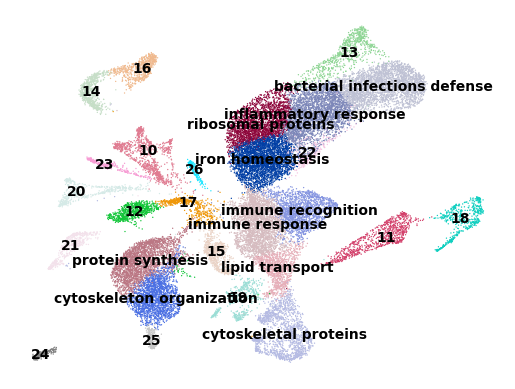

In [315]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)


In [336]:
marker_genes = ['LTF', 'AHSP',
               'S100A8', 'S100A9',
               'DEFA3', 'PRTN3', 'LYZ', 'BPI',
               'CAMP', 'LGALS1', 'ELANE', 'CD74',
#                'FTH1', 'RPS27', 'RPL13A', 'RPS4X',
#                'RPL10', 'RPS16', 'RPL13', 'RPL7A',
#                'VIM', 'LGALS1',
#                'HLA-A',
#                 'ACTB',
                'TPM2',
               'APOE', 'SLC4A1',
               'ATP2B1', 'DGKD',]

C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


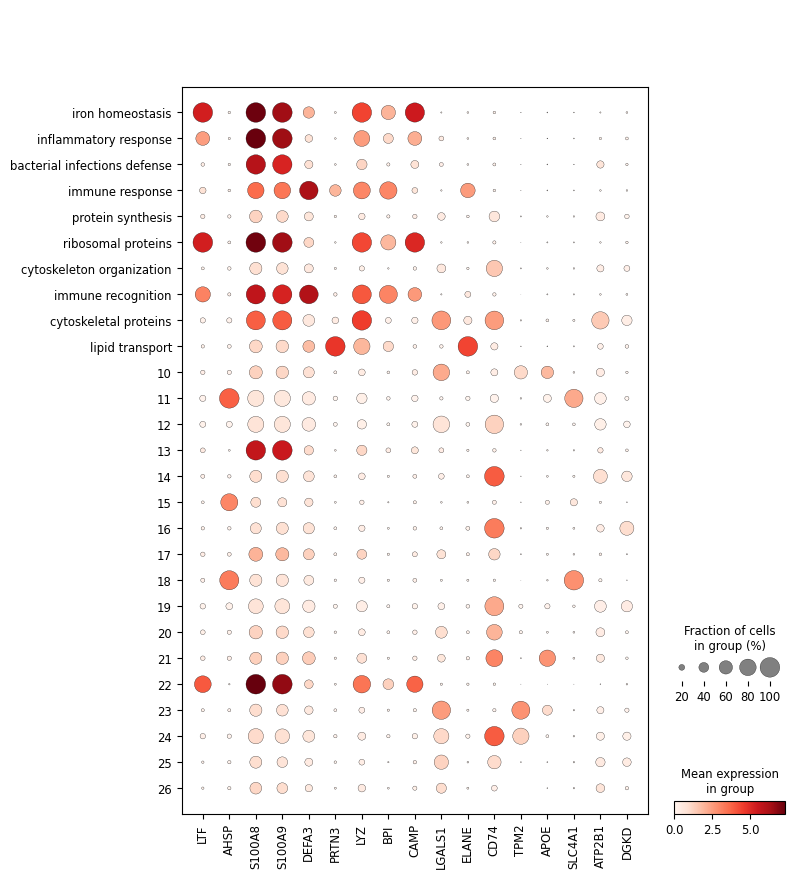

In [337]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');


There is limited research on the specific role of **DGKD** gene in bone tissues. However, some studies suggest that DGKD may be involved in bone metabolism and may play a role in bone diseases. For example, a study published in the Journal of Cellular Physiology in 2018 found that DGKD is upregulated in osteoarthritis (OA) cartilage, and may contribute to the pathogenesis of OA by regulating chondrocyte apoptosis and inflammatory responses. Another study published in the Journal of Orthopaedic Research in 2019 found that DGKD is downregulated in osteoporotic bone tissue, and may be a potential therapeutic target for the treatment of osteoporosis. Overall, more research is needed to fully understand the role of DGKD in bone tissues.

## Genes to be considered according to https://academic.oup.com/ndt/article/29/suppl_4/iv55/1908818:
startswith:
- PTH
- CYP27A1
- CYP2R1
- CYP27B1
- FGF23
- VDR
- GATA3
- CARS
- DGKD
- DGKH
- NADSYN1
- GC
- DHCR7
- 

Genes Not effecting according to the paper, but are related to calcium synthesis:
- TRPV5
- TRPV6
- ATP2B1
- SLC8A1